<a href="https://colab.research.google.com/github/tasuni/Music-Generation/blob/main/Music_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Synthesis





TO-DO: 

---

1.   ~Figure out a way to represent data~
2.   ~Build base LSTM~
3.   ~Sample new sequences from the model~
4.   ~Try Embeddings~
5.   Try Stratified split of some sort to better represent the model
6.   Try Advanced Sequence Generation Models
7.   Try mixing genres
8.   Try to introduce the temporal aspect

### Imports

In [ ]:
import glob
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split

from music21 import note, chord, converter, stream, instrument, midi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Specify device for the model to run on
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading Dataset

In [ ]:
!mkdir dataset

In [ ]:
!unzip -q all_artists.zip

unzip:  cannot find or open all_artists.zip, all_artists.zip.zip or all_artists.zip.ZIP.


In [ ]:
!unzip -q \*.zip -x all_artists.zip -d dataset

caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not matched:  all_artists.zip
caution: excluded filename not 

### Preprocessing and Generating Dataset from raw midi

In [ ]:
def get_notes(root):
  """
  Returns a list of notes of all the songs in a root directory
  Input : 
  root - root folder path
  Output : 
  notes - A single list containing notes of all the songs in the root directory in a sequential manner.
  """
  notes = []
  unprocessed_notes = None

  for midi_file in tqdm(glob.glob(f"{root}/*.mid")):
    song = converter.parse(midi_file)

    for component in song.recurse():
      if isinstance(component, note.Note):
        notes.append(component.name)
      elif isinstance(component, chord.Chord):
        notes.append(','.join(str(n) for n in component.normalOrder))
  
  return notes

In [ ]:
def get_info(notes):
  """
  Get a list of all unique notes, and dictionaries to convert notes to int and back
  Input : 
  notes - A list of all the notes present in our music dataset
  Output : 
  unique_notes - A list containing all the unique notes present in our dataset.
  note_to_int  - A dictionary that maps a given note string to an int.
  int_to_note  - A dictionary that maps a given int to a string.

  NOTE:
  If note_to_int[note_name] = i
  Then, int_to_note[i] = note_name
  """

  unique_notes = list(set(notes))
  enumerated_uniques = enumerate(sorted(unique_notes))
  note_to_int = dict((note, i) for i, note in enumerated_uniques)
  enumerated_uniques = enumerate(sorted(unique_notes))
  int_to_note = dict((i, note) for i, note in enumerated_uniques)

  return unique_notes, note_to_int, int_to_note

In [ ]:
def get_dataloader(notes, note_to_int, sequence_length, vocab_length, batch_size=64):
  """
  Gets a dataloader object back, which is used to convert our dataset into batches

  Input:
  notes           - A list of all the notes present in our music dataset.
  note_to_int     - A dictionary that maps a given note string to an int.
  sequence_length - Number of notes in each sequence.
  vocab_length    - Number of unique notes in the dataset
  batch_size      - Batch size for training.

  Output:
  X      - List of input tensors, used for sampling later
  loader - Dataloader object 
  """
  X = []
  y = []
  
  # for the first x notes taken as input, get the next note as output
  for i in range(0, len(notes) - sequence_length):
    X.append([note_to_int[note] for note in notes[i : i + sequence_length]])
    y.append(note_to_int[notes[i + sequence_length]])
  
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
  
  X_train = torch.tensor(X_train)
  y_train = torch.tensor(y_train)

  X_test = torch.tensor(X_test)
  y_test = torch.tensor(y_test)


  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)

  test_dataset = TensorDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

  return X, train_loader, test_loader

### Create Model

In [ ]:
class MusicSynthesis(nn.Module):
  """LSTM base model"""
  def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, dropout, num_classes, input_size):
    super(MusicSynthesis, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, 
                        num_layers=num_layers, bidirectional=True, batch_first=True)
    self.lstm2 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True)
    self.lstm3 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_size*2, 64)
    self.dropout = nn.Dropout()
    self.linear2 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.embedding(x)
    h, (_, _) = self.lstm(x)
    h, (_, _) = self.lstm2(h)
    h, (_, _) = self.lstm3(h)
    x = self.linear(h[:,-1,:])
    x = self.dropout(x)
    x = self.linear2(x)

    return x

### Training Function

In [ ]:
def get_accuracy(outputs, labels):
  """
  Get accuracy of each batch

  Input:
  outputs - Output tensor from the model
  labels  - Tensor containing the true labels

  Output:
  Accuracy of the given batch
  """
  outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
  outputs = outputs.detach().cpu()
  labels = labels.detach().cpu()
  correct = (outputs==labels).sum()
  total = len(labels)

  return correct/total

In [ ]:
def train_model(epochs, trainloader, testloader, model, optimizer, loss_function, vocab_size):
  """
  Base function to train the model in one go, good for orthogonality.

  Input:
  epochs        - Number of training epochs.
  dataloader    - DataLoader object.
  model         - Model that needs to be trained.
  optimizer     - Optimizer selected for the model.
  loss_function - Loss function for backpropagation.
  vocab_size    - Number of unique notes in our dataset.

  Output:
  losses   - List containing losses of each epoch
  accuracy - List containing accuracies of each epoch
  """
  training_losses = []
  training_accuracy = []
  test_losses = []
  test_accuracy = []

  for epoch in range(epochs):
    tr_epoch_loss = []
    tr_epoch_accuracy = []
    te_epoch_loss = []
    te_epoch_accuracy = []

    for data in tqdm(trainloader):
      inputs, labels = data
      labels.squeeze_()
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      model.train()
      optimizer.zero_grad()
      
      outputs = model(inputs)
      outputs = outputs
      loss = loss_function(outputs, labels)

      tr_epoch_accuracy.append(get_accuracy(outputs, labels))
      tr_epoch_loss.append(loss.item())
      loss.backward()
      optimizer.step()
          
    curr_tr_acc = np.mean(tr_epoch_accuracy)
    curr_tr_loss = np.mean(tr_epoch_loss)
    training_accuracy.append(curr_tr_acc)
    training_losses.append(curr_tr_loss)
    
  
    with torch.no_grad():
      for data in testloader:
        inputs, labels = data
        labels = labels.squeeze()
        inputs = inputs.to(device)
        labels = labels.to(device)

        model.eval()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        te_epoch_accuracy.append(get_accuracy(outputs, labels))
        te_epoch_loss.append(loss.item())
    
    curr_te_acc = np.mean(te_epoch_accuracy)
    curr_te_loss = np.mean(te_epoch_loss)
    test_accuracy.append(curr_te_acc)
    test_losses.append(curr_te_loss)

    print(f"Epoch {epoch + 1:003}")
    print(f"Training Loss = {curr_tr_loss:.3f} Training Accuracy = {curr_tr_acc*100:.3f}")
    print(f"Validation Loss = {curr_te_loss:.3f} Validation Accuracy = {curr_te_acc*100:.3f}")

  print("Training Done")

  return training_losses, training_accuracy, test_losses, test_accuracy

### Testing

In [ ]:
notes_dataset = get_notes("dataset")

  0%|          | 0/292 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# save to file
with open("notes_dataset.txt", "wb") as file_:
  pickle.dump(notes_dataset, file_)

In [ ]:
# open from an existing file
with open("notes_dataset.txt", "rb") as file_:
  notes_dataset = pickle.load(file_)

In [ ]:
vocab, note_to_int, int_to_note = get_info(notes_dataset)

In [ ]:
SEQ_LEN = 100
VOCAB_LEN = len(vocab)

X, trainloader, testloader = get_dataloader(notes_dataset, note_to_int, SEQ_LEN, VOCAB_LEN)

In [ ]:
model = MusicSynthesis(VOCAB_LEN, 50, hidden_size=256, num_layers=1, 
                       dropout=0.3, num_classes=VOCAB_LEN, input_size=1)

In [ ]:
model.to(device)

MusicSynthesis(
  (embedding): Embedding(409, 50)
  (lstm): LSTM(50, 256, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 256, batch_first=True, bidirectional=True)
  (lstm3): LSTM(512, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=64, out_features=409, bias=True)
)

In [ ]:
model.load_state_dict(torch.load("biLSTM-model-with-embeddings-256h-1l.pth"))

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
EPOCHS = 10

loss, accuracy = train_model(epochs=EPOCHS, trainloader=trainloader, testloader=testloader, model=model, 
                    optimizer=optimizer, loss_function=criterion, vocab_size=VOCAB_LEN)


Epoch 001
Training Loss = 1.247 Training Accuracy = 67.979
Validation Loss = 1.164 Validation Accuracy = 68.852



Epoch 002
Training Loss = 1.169 Training Accuracy = 69.124
Validation Loss = 1.237 Validation Accuracy = 67.161



Epoch 003
Training Loss = 1.116 Training Accuracy = 70.217
Validation Loss = 1.305 Validation Accuracy = 66.001



Epoch 004
Training Loss = 1.077 Training Accuracy = 71.034
Validation Loss = 1.365 Validation Accuracy = 65.001



Epoch 005
Training Loss = 1.050 Training Accuracy = 71.581
Validation Loss = 1.412 Validation Accuracy = 64.502



Epoch 006
Training Loss = 1.018 Training Accuracy = 72.325
Validation Loss = 1.469 Validation Accuracy = 63.772



Epoch 007
Training Loss = 1.004 Training Accuracy = 72.687
Validation Loss = 1.498 Validation Accuracy = 63.505



Epoch 008
Training Loss = 0.977 Training Accuracy = 73.323
Validation Loss = 1.529 Validation Accuracy = 63.457



Epoch 009
Training Loss = 0.956 Training Accuracy = 73.803
Validation Loss = 1.572 Validation Accuracy = 62.877


In [ ]:
MODEL_PATH = "./biLSTM-model-with-embeddings-256h-1l.pth"

torch.save(model.state_dict(), MODEL_PATH)

ValueError: ignored

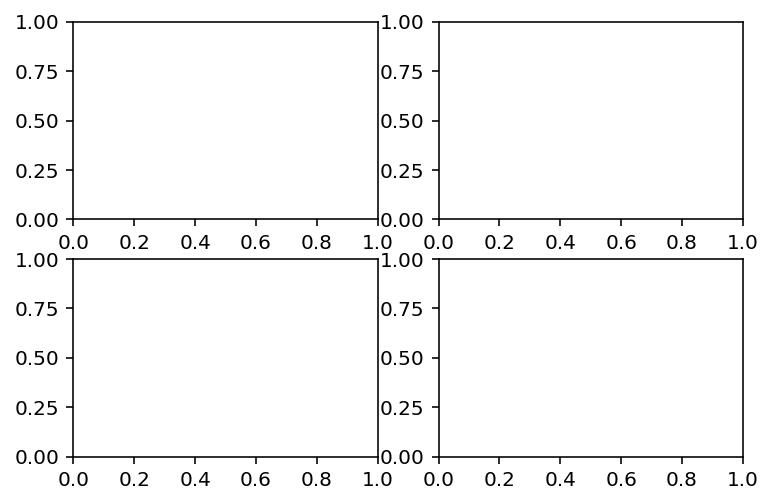

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2)
ax1.plot(loss)
ax2.plot(accuracy)
ax1.set_xlabel("Loss")
ax2.set_xlabel("Accuracy")
plt.show()

In [ ]:
X = torch.tensor(X)

### Sampling

In [ ]:
def sample(model, file_name, vocab_len, base_offset, sample_len):
  """
  Function to sample new sequences from the trained model.

  Inputs:
  model       - Trained model
  file_name   - Name of the output midi file
  vocab_len   - Number of unique notes in our dataset
  base_offset - Time difference between each note
  sample_len  - Number of notes/chords to sample

  Outputs:
  none
  Writes the sampled midi song onto a file specified by file_name
  """

  offset = 0
  input = np.random.randint(0, len(X)-1)
  network_input = (X[input]).unsqueeze(0).to(device)
  music = []
  notes = []
  model.eval()

  for i in range(sample_len):
    prediction = model(network_input)
    idx = torch.argmax(prediction, dim=1) # Get index of the predicted note
    result = int_to_note[idx.item()]
    notes.append(result)
    #Convert idx to a network appropriate tensor
    idx_tensor = torch.tensor([idx]).unsqueeze(-1).to(device)
    network_input = torch.cat((network_input, idx_tensor), dim=1)
    network_input = network_input[:,1:network_input.shape[1] + 1]
  
  inp_notes = [int_to_note[int(i.item())] for i in (X[input])]
  # notes = inp_notes + notes
  # notes = [int_to_note[n] for n in notes]
  print(inp_notes)
  print(notes)

  for n in notes:
    chord_list = []
    if ',' in n: # n is a chord
      chord_list = n.split(",")
      chord_list = [int(c) for c in chord_list]
      new_chord = chord.Chord(chord_list)
      new_chord.offset = offset
      music.append(new_chord)
    else: # n is a note
      if n == '': continue
      new_note = note.Note(n)
      new_note.offset = offset
      music.append(new_note)
    
    offset += base_offset

  output_stream = stream.Stream(music)

  midi_file = midi.translate.streamToMidiFile(output_stream)
  midi_file.open(f'{file_name}.mid', 'wb')
  midi_file.write()
  midi_file.close()

In [ ]:
sample(model, "outputs", VOCAB_LEN, 0.60, 100)

['4,8', '3,7', 'B-', 'E-', '11,3', '11,3', '11,3', '11,3', '11,3', '4,8', '4,8', '4,8', '4,8', '4,8', 'F#', '4,8', '8,11', '8,11', '4,8', '3,7', 'B-', 'E-', 'E-', 'B-', 'E-', 'C#', 'B-', 'C', 'B-', 'G#', 'F', 'G', 'E-', 'F', 'E-', 'G', 'F', 'G', 'G', 'D', 'E', 'G', 'F', 'D', 'E', 'G', 'F', 'E-', 'D', 'C', 'B-', 'G', 'F#', 'G', 'G#', 'E-', 'E-', 'E-', 'G', 'F#', 'G', 'A', 'B-', 'A', 'B-', 'C', 'F#', 'F#', 'F#', 'F#', 'F#', 'F#', 'B-', 'A', 'B-', 'C#', 'G', 'G', 'C', 'B-', 'C', 'B-', 'G#', 'G', 'G', 'F', 'E-', 'E-', 'E-', 'E-', 'E-', 'F', 'E-', 'E-', 'F', 'E-', 'F#', '0,3', 'C#', 'F#']
['F', 'F', 'E-', 'C#', 'B-', 'E-', 'C#', 'C', 'E-', 'B-', 'F', 'F', 'F', 'F', 'E-', 'C#', 'C', 'C#', 'B-', 'E-', 'C#', 'C', 'E-', 'E-', 'E-', 'G#', 'E-', 'C#', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B-', 'C', 'B